# *German Traffic Sign Recognizer*

based on this Jupyter Notebook: https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy

In [1]:
TRAINING_TEST_SPLIT = 0.5
TRAINING_TEST_SPLIT_NAME = '50-50'
ACTIVATION_FUNCTION = 'tanh'
TRAINING_SESSION = 1
TRAINING_EPOCHS = 5

In [2]:
RANDOM_SEED = 42

DATA_DIR = './data'
TRAIN_PATH = './data/Train'
TEST_PATH = './data'
IMAGE_PATH = './result/images'
RESULT_FILE = './result/result.csv'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
IMG_COLOR_CHANNELS = 3

# Label Overview
CLASSES = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

NUMBER_OF_CATEGORIES = len(CLASSES)

## Importing Required Libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.keras import layers, models, layers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image

np.random.seed(RANDOM_SEED)

style.use('fivethirtyeight')

2023-02-28 18:13:11.020490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 18:13:13.243097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/steve/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-28 18:13:13.243236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/steve/miniconda3/envs/tf/lib/python3.9/site-pack

## Visualizing The Dataset

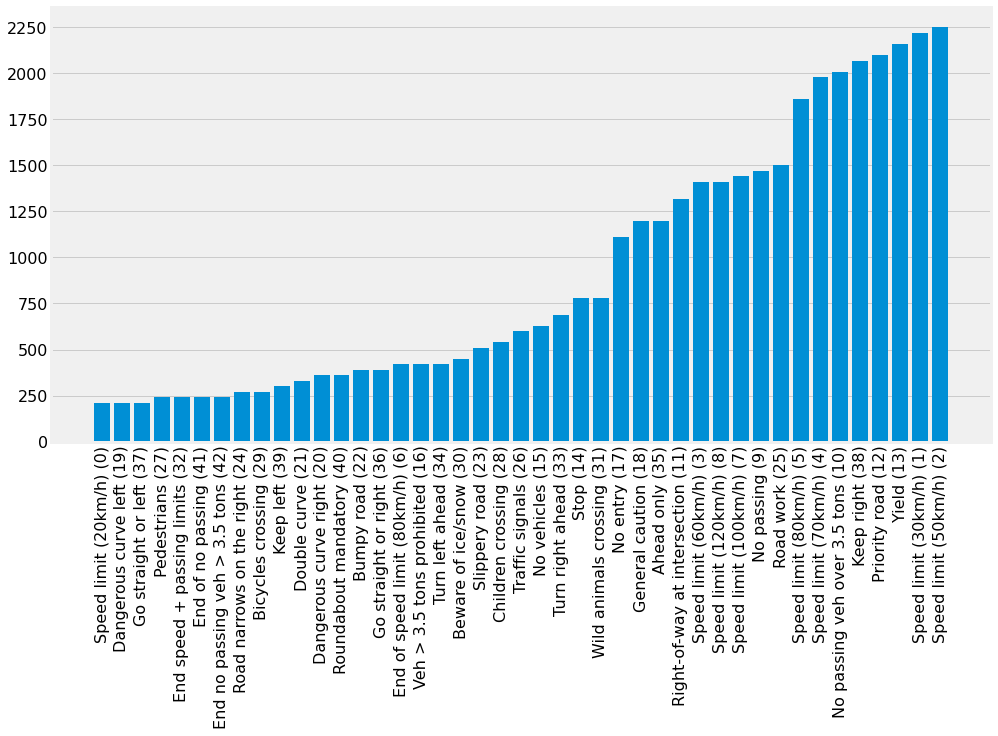

In [4]:
folders = os.listdir(TRAIN_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append((int(folder), CLASSES[int(folder)]))
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15, 8))  
plt.bar([i[1] for i in class_num], train_number)
plt.xticks([i[1] for i in class_num], labels=[f"{i[1]} ({i[0]})" for i in class_num], rotation='vertical', fontsize=16)
plt.yticks(list(range(0, 2251, 250)), fontsize=16)
plt.grid(axis="x")

plt.show()

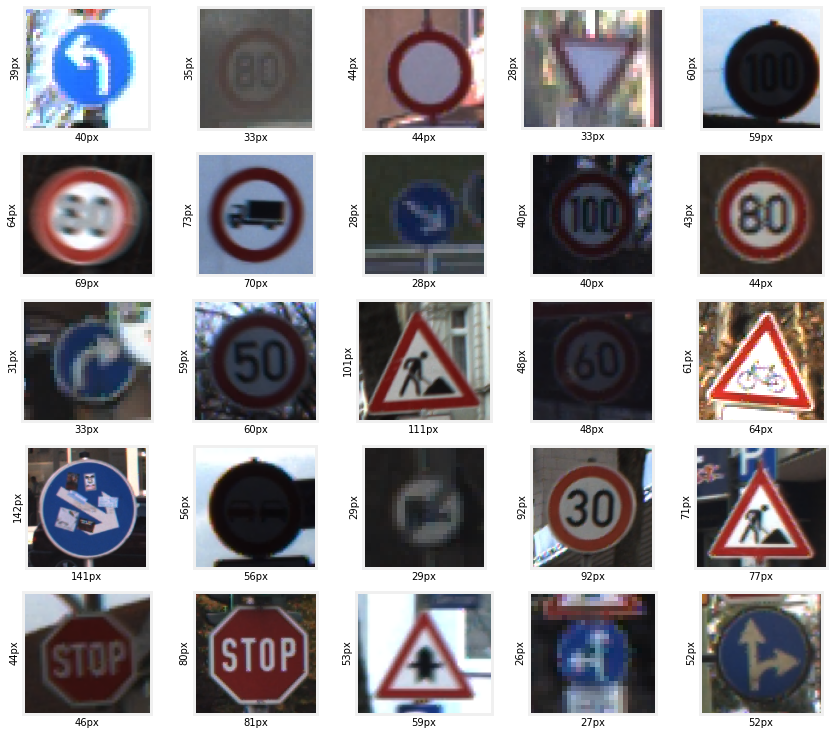

In [5]:
from matplotlib.image import imread

test = pd.read_csv(DATA_DIR + '/Test.csv')
imgs: list[str] = list(test["Path"].values)

plt.figure(figsize=(13, 13))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = DATA_DIR + '/' + np.random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(f"{rand_img.shape[1]}px", fontsize = 10)
    plt.ylabel(f"{rand_img.shape[0]}px", fontsize = 10)

## Collecting the Training Data

In [6]:
image_data = []
image_labels = []

for i in range(NUMBER_OF_CATEGORIES):
    path = DATA_DIR + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [7]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [8]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=TRAINING_TEST_SPLIT, random_state=42, shuffle=True)

X_train = X_train / 255.0 
X_val = X_val / 255.0

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (19604, 30, 30, 3)
X_valid.shape (19605, 30, 30, 3)
y_train.shape (19604,)
y_valid.shape (19605,)


## One hot encoding the labels

In [9]:
y_train = utils.to_categorical(y_train, NUMBER_OF_CATEGORIES)
y_val = utils.to_categorical(y_val, NUMBER_OF_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(19604, 43)
(19605, 43)


## Making the model

In [10]:
model = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation=ACTIVATION_FUNCTION, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_COLOR_CHANNELS)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation=ACTIVATION_FUNCTION),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation=ACTIVATION_FUNCTION),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation=ACTIVATION_FUNCTION),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Flatten(),
    layers.Dense(512, activation=ACTIVATION_FUNCTION),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(NUMBER_OF_CATEGORIES, activation='softmax')
])

2023-02-28 18:13:45.775795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 18:13:45.804595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 18:13:45.804677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 18:13:45.805988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

## Augmenting the data and training the model

In [12]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

from time import time

start_time = time()

history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=TRAINING_EPOCHS,
    validation_data=(X_val, y_val)
)

training_time = round(time() - start_time, 1)
print("training time:", training_time)

Epoch 1/5


2023-02-28 18:13:55.297818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-02-28 18:13:59.778193: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-28 18:14:02.558923: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d57e3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 18:14:02.559075: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-02-28 18:14:02.769094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-28 18:14:03.536886: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-28 18:14:03.598648: I tensorflow/compiler/jit/xla_compilatio

613/613 [==============================] - 45s 44ms/step - loss: 1.7046 - accuracy: 0.5481 - val_loss: 0.7827 - val_accuracy: 0.7673
Epoch 2/5
613/613 [==============================] - 19s 30ms/step - loss: 0.6080 - accuracy: 0.8159 - val_loss: 0.1987 - val_accuracy: 0.9455
Epoch 3/5
613/613 [==============================] - 19s 31ms/step - loss: 0.3834 - accuracy: 0.8846 - val_loss: 0.1153 - val_accuracy: 0.9642
Epoch 4/5
613/613 [==============================] - 21s 34ms/step - loss: 0.3001 - accuracy: 0.9092 - val_loss: 0.0479 - val_accuracy: 0.9884
Epoch 5/5
613/613 [==============================] - 19s 32ms/step - loss: 0.2407 - accuracy: 0.9271 - val_loss: 0.0400 - val_accuracy: 0.9894
training time: 122.9


## Evaluating the model

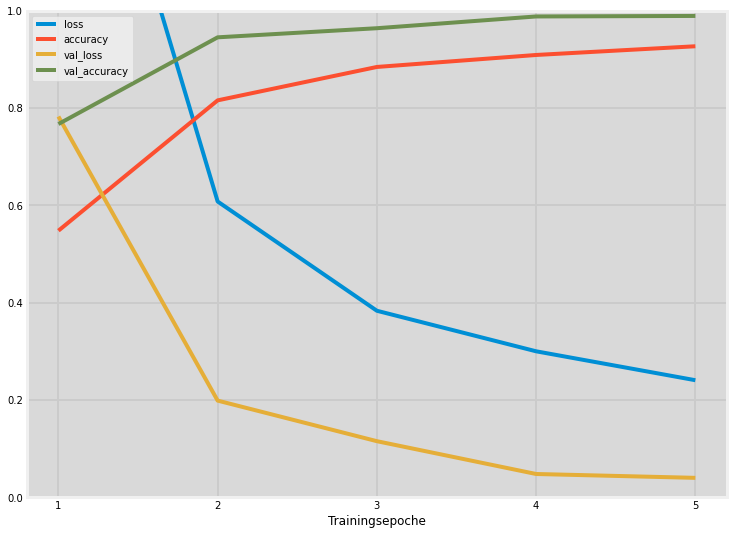

In [13]:
pd.DataFrame(history.history).plot(figsize=(10, 7), linewidth=4.0).set_facecolor((0.85, 0.85, 0.85))
plt.grid(True, linewidth=2)
plt.xticks(np.arange(0, TRAINING_EPOCHS, 1), labels=list(range(1, TRAINING_EPOCHS + 1)))
plt.gca().set_ylim(0, 1)
plt.tight_layout(pad=0)
plt.xlabel("Trainingsepoche")
plt.savefig(f"{IMAGE_PATH}/{TRAINING_TEST_SPLIT_NAME}/{ACTIVATION_FUNCTION}/evaluation_{TRAINING_SESSION}.png", bbox_inches='tight', pad_inches=0.01)
plt.show()

## Loading the test data and running the predictions

In [14]:
test = pd.read_csv(DATA_DIR + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(DATA_DIR + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
        
X_test = np.array(data) / 255.0

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

#Accuracy with the test data
test_accuracy = round(accuracy_score(labels, pred), 4)
print('Test Data accuracy: ', test_accuracy)

395/395 [==============================] - 2s 5ms/step
Test Data accuracy:  0.9637


## Visualizing the confusion matrix

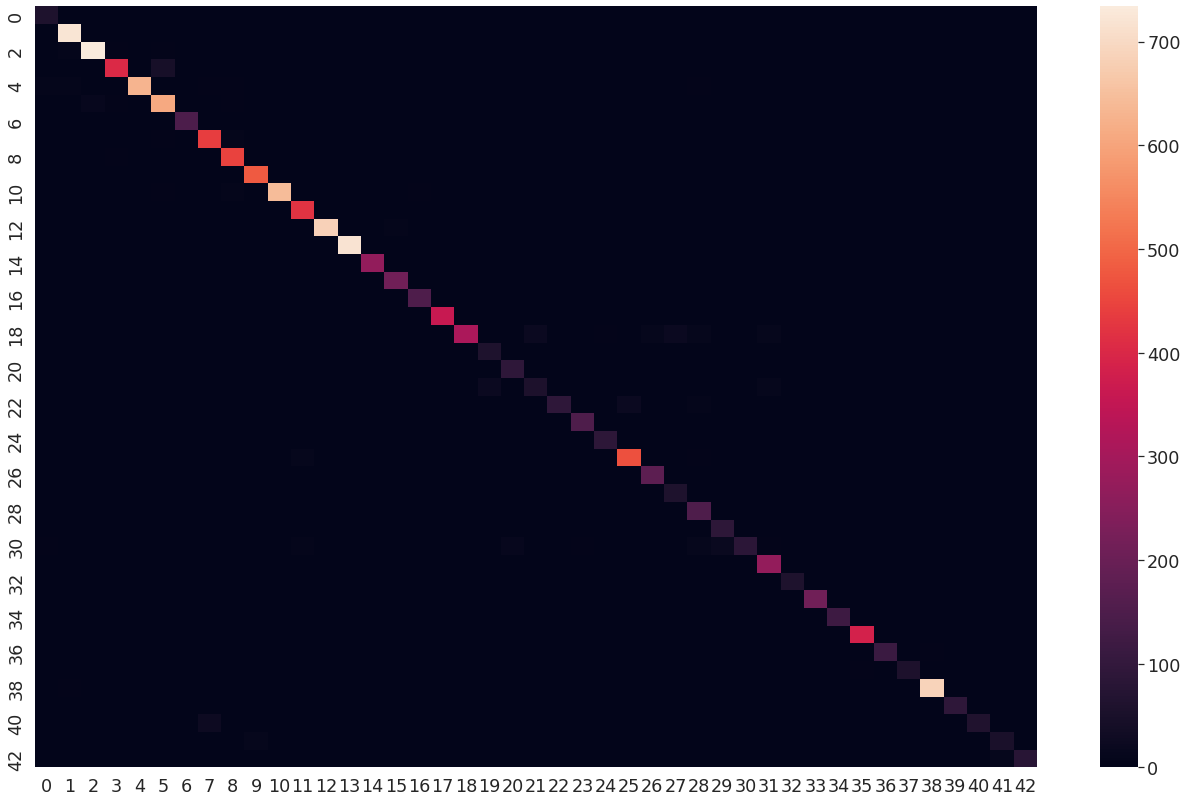

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn

cf = confusion_matrix(labels, pred)
df_cm = pd.DataFrame(cf, index=CLASSES, columns=CLASSES)
plt.figure(figsize = (20, 14))
seaborn.set(font_scale=1.6)
seaborn.heatmap(df_cm)
plt.savefig(f"{IMAGE_PATH}/{TRAINING_TEST_SPLIT_NAME}/{ACTIVATION_FUNCTION}/confusion_matrix_{TRAINING_SESSION}.png", bbox_inches='tight', pad_inches=0.01)
plt.show()

## Classification report

In [16]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        60
           1       0.97      1.00      0.98       720
           2       0.98      0.98      0.98       750
           3       0.98      0.89      0.93       450
           4       1.00      0.95      0.98       660
           5       0.91      0.97      0.94       630
           6       0.99      0.99      0.99       150
           7       0.93      0.97      0.95       450
           8       0.95      0.99      0.97       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.99       660
          11       0.95      1.00      0.98       420
          12       1.00      0.99      1.00       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.97      1.00      0.98       210
          16       0.97      1.00      0.99       150
          17       0.99    

## Predictions on Test Data

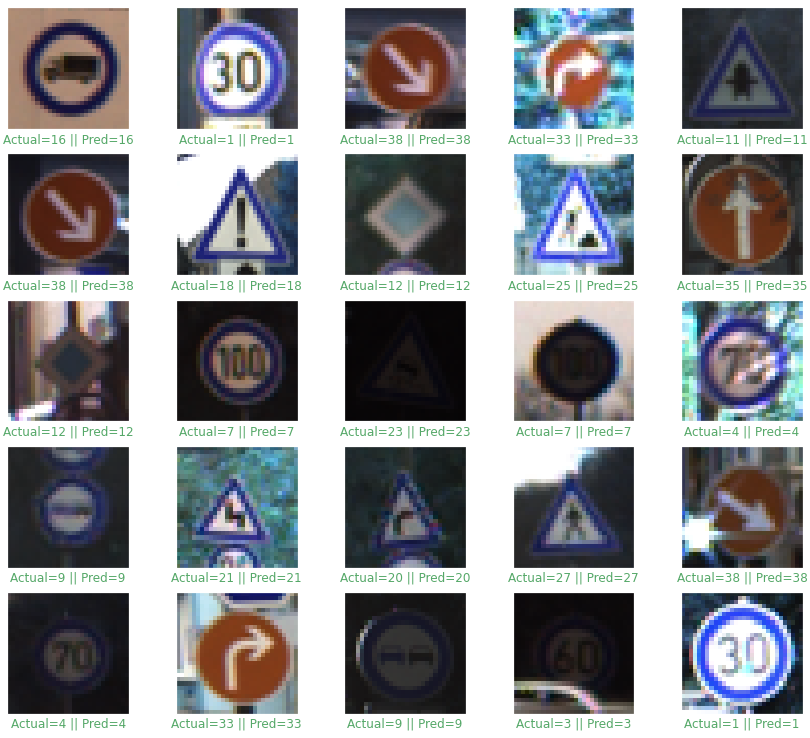

In [17]:
plt.figure(figsize = (13, 13))

for i in range(25):
    prediction = pred[i]
    actual = labels[i]

    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    color = 'g' if prediction == actual else 'r'
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=color, fontsize=12)
    plt.imshow(X_test[i])

plt.show()

## Collecting the result

In [ ]:
final_validation_accuracy = round(history.history["val_accuracy"][TRAINING_EPOCHS - 1], 4)

with open(RESULT_FILE, "a") as result_file:
    result_file.write(f"{TRAINING_TEST_SPLIT_NAME},{ACTIVATION_FUNCTION},{TRAINING_SESSION},{training_time},{final_validation_accuracy},{test_accuracy}\n")
